In [1]:
"""
Transform accumulated changes from fMRI layers into durations (s) using
multiclass SVM
"""

'\nTransform accumulated changes from fMRI layers into durations (s) using\nmulticlass SVM\n'

# IMPORT LIBS AND DATA 

In [1]:
from sklearn.svm import SVR
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import scipy.io as sio
import scipy.stats as stats
from scipy import signal
import os.path as op
import os
from sklearn.base import clone
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import chi2
import glob
from time import time
import statistics

#Device configuration
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
#from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import scipy.stats as stats
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

outdir = 'D:\\ERICK\\MD\\prediction_data\\'
datadir = 'D:\\ERICK\\MD\\'
load_file = op.join(datadir, 'master_dataset.csv')
data = pd.read_csv(load_file)

In [1]:
import warnings
warnings.filterwarnings("ignore")
task = 'bias'
region = 'rGlasser'
n_nodes = 64620

# load data
durations = [8, 12, 16, 20, 24]
videoTypes = [0, 1] #office, city
rooth = op.join(datadir, 'extracted_voxels')
excluded = [10, 12, 41, 45]
load_file = op.join(datadir, 'master_dataset.csv')
df = pd.read_csv(load_file)

def standardize(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    standardized_data = (data - mean) / std
    return standardized_data

fc_data = [] 
outcome = []
for sub in range(4, 46):
    print(sub)
    if sub in excluded:
        print('skipping subject')
        continue
    for run in range(1, 5):
        if not task=='videoType':
            for trial in range(1, 21):
                subset = df.loc[(df['rawSubjID'] == sub) & (df['run'] == run) & (df['trial'] == trial)]
                if len(subset)!=0:
                    hr = float(subset['humanReport'].values)
                    bias = float(subset['humanBias'].values)
                    fcMatFile = op.join(rooth, str(sub), 'FC', 'rGlasserFC_run'+str(run)+'_trial'+str(trial)+'.mat')
                    if op.isfile(fcMatFile):
                        print(hr, fcMatFile)
                        outcome.append(bias)
                        data = sio.loadmat(fcMatFile)
                        fdata = data['fc']
                        fc_data.append(fdata)
                        del data
                else:
                    print(f'Inexistent data for subj {sub}, run = {run}, trial = {trial}')
                    continue

        if task=='videoType':
            for vid in videoTypes:
                num_components = -1
                run_data = []
                for trial in range(1, 21):
                    subset = df.loc[(df['rawSubjID'] == sub) & (df['run'] == run) & (df['trial'] == trial)]
                    try:
                        hr = float(subset['humanReport'].values)
                        if hr.is_integer():
                            hr = int(hr)
                        else:
                            hr = hr
                        vt = int(subset['isCity'].values)
                        if not region=='rGlasser':
                            tsMatFile = op.join(tsdir, str(sub), 'time_series', region+'TS_run'+str(run)+'_trial'+str(trial)+'_dur='+str(hr)+'.mat')

                        else:
                            tsMatFile = op.join(tsdir, str(sub), 'rGlasserTS_run'+str(run)+'_trial'+str(trial)+'_dur='+str(hr)+'.mat')

                        if op.isfile(tsMatFile) and subset['isCity'].values==vid:
                            print(tsMatFile)
                            outcome.append(vt)
                            data = sio.loadmat(tsMatFile)
                            fdata = data['avg_data'][~np.isnan(data['avg_data']).any(axis=1)]
                            run_data.append(fdata)
                            
                            del data
        
                    except:
                        continue
                    
                try:
                    run_data = np.concatenate(run_data, axis=1)
                    print(run_data.shape)
                    ts_data.append(run_data)
                except:
                    print(f'Inexistent data for subj {sub}, run = {run}, duration = {dur}')
     
fc_data = np.concatenate(fc_data, axis=1)
fc_data = standardize(fc_data)
fc_data = fc_data.reshape(-1, n_edges)
# fc_data = torch.tensor(fc_data, dtype=torch.float32) 
if task=='verDur' or task=='bias':
    outcome = standardize(outcome)
    outcome = outcome.reshape(len(outcome), 1)
## final shape: [trials, region, ts]

In [11]:
fc_data.shape

(2040, 64620)

# Elastic-net

In [2]:
# create FC matrices
def partialcorr_via_inverse(X):
    # standardize
    X -= X.mean(axis=0)
    X /= X.std(axis=0)
    X[np.isnan(X)]=0
    # correlation
    emp_corr = np.dot(X.T, X) / X.shape[0]
    return emp_corr
def standardize(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    standardized_data = (data - mean) / std
    return standardized_data

import warnings
warnings.filterwarnings("ignore")

task = 'realDur'
mode = 'random_corr'
data_type = 'smoothed'
thr = 'nulo'
region = 'rGlasser'
print('-------> Loading data for these parameters:')
print(f'TASK = {task}, MODE = {mode}, DATA TYPE = {data_type}, THR = {thr} and REGION = {region}')

if region=='rGlasser':
    n_regions = 360 #glasser atlas
    n_edges = 64620
    triu_idx = np.triu_indices(n_regions ,1)
    region_idx = np.arange(0, 360, 1)
elif region=='visualNet':
    n_regions = 56 #only visual
    n_edges = 1540
    triu_idx = np.triu_indices(n_regions ,1)
    load_file = op.join(datadir, 'ROIs for analysis', 'rGlasser_visual_index.txt')
    region_idx = np.loadtxt(load_file)
    region_idx = [int(value)-1 for value in region_idx]
elif region=='dan':
    n_regions = 23 
    n_edges = 253
    triu_idx = np.triu_indices(n_regions ,1)
    load_file = op.join(datadir, 'ROIs for analysis', 'rGlasser_dan_index.txt')
    region_idx = np.loadtxt(load_file)
    region_idx = [int(value)-1 for value in region_idx]
elif region=='cingNet':
    n_regions = 53 
    n_edges = 1378
    triu_idx = np.triu_indices(n_regions ,1)
    load_file = op.join(datadir, 'ROIs for analysis', 'rGlasser_con_index.txt')
    region_idx = np.loadtxt(load_file)
    region_idx = [int(value)-1 for value in region_idx]
elif region=='dmn':
    n_regions = 77 
    n_edges = 2926
    triu_idx = np.triu_indices(n_regions ,1)
    load_file = op.join(datadir, 'ROIs for analysis', 'rGlasser_dmn_index.txt')
    region_idx = np.loadtxt(load_file)
    region_idx = [int(value)-1 for value in region_idx]
if region=='rShen':
    n_regions = 268 
    n_edges = int((n_regions**2 - n_regions)/2)
    triu_idx = np.triu_indices(n_regions ,1)
    region_idx = np.arange(0, n_regions, 1)
if region=='DL':
    n_regions = 77 
    n_edges = int((n_regions**2 - n_regions)/2)
    triu_idx = np.triu_indices(n_regions ,1)
    region_idx = np.arange(0, n_regions, 1)
if region=='ICA':
    n_regions = 99
    n_edges = int((n_regions**2 - n_regions)/2)
    triu_idx = np.triu_indices(n_regions ,1)
    region_idx = np.arange(0, n_regions, 1)

# load data
durations = {8:11, 12:16, 16:21, 20:26, 24:31} #dur:ts_size
videoTypes = [0, 1] #office, city
if task == 'videoType':
    iters = videoTypes
    label = 'isCity'
else:
    iters = durations
    label = 'veridicalDuration' 
excluded = [8, 9, 41, 45] # 8 e 9 não existem, 10 tem dados incompletos
load_file = op.join(datadir, 'master_dataset.csv')
df = pd.read_csv(load_file)

fc_data = []
outcome = []
real_dur = []
samples = []
subj_list = []
i=0

for sub in range(4, 46):
    if sub in excluded:
        print('skipping subject')
        continue
    subj_list.append(sub)
    for run in range(1, 5):
        print(f'subj {sub}, run {run}')
        init = 0 # initialise iteration for ICA-ts extraction
        for j in iters:
            run_data = []
            bias_list = []
            hr_list = []
            for trial in range(1, 21):
                subset = df.loc[(df['rawSubjID'] == sub) & (df['run'] == run) & (df['trial'] == trial)] # & (df['isCity'] == 1)] 
                if len(subset)!=0:
                    hr = float(subset['humanReport'].values)
                    vt = int(subset['isCity'].values)
                    hb = float(subset['humanBias'].values)
                    dur = int(subset['veridicalDuration'].values)
                    acc = float(subset['estimationAcc'].values)
                    if thr!='nulo':
                        if hr<((1-thr)*j) or hr>((1+thr)*j):
                            print('Skipping trial due to large estimation error')
                            continue
            
                    if data_type=='smoothed' or data_type=='dubois_pipeline':
                        if hr.is_integer():
                            hr = int(hr)
                        else:
                            hr = hr
                    
                    if mode=='corr':
                        tsdir = op.join(datadir, 'extracted_voxels', str(sub), 'time_series')
                        tsMatFile = op.join(tsdir, 'rGlasserTS_run'+str(run)+'_trial'+str(trial)+'_dur='+str(hr)+'.mat')
                        if data_type=='smoothed':
                            tsdir = op.join(datadir, 'extracted_voxels', str(sub), 'time_series', 'smoothed')
                            tsMatFile = op.join(tsdir, 'rGlasserTS_run'+str(run)+'_trial'+str(trial)+'_dur='+str(hr)+'.mat')
                            if region=='rShen':
                                tsMatFile = op.join(tsdir, 'rShenTS_run'+str(run)+'_trial'+str(trial)+'_dur='+str(hr)+'.mat')
                        if data_type=='dubois_pipeline':
                            tsdir = op.join(datadir, 'extracted_voxels', str(sub), 'time_series', 'dubois_pipeline')
                            tsMatFile = op.join(tsdir, 'rGlasserTS_run'+str(run)+'_trial'+str(trial)+'_dur='+str(hr)+'.mat')

                    if mode=='random_corr': # whole_TS is the time-series from full block, not only task-related trials
                        tsdir = r'C:\Users\erick\Documents\mestrado\extracted_voxels'
                        tsMatFile = op.join(tsdir, str(sub), 'whole_TS', 'rGlasserTS_run'+str(run)+'.mat')
                        if data_type=='smoothed':
                            tsdir = op.join(tsdir, str(sub), 'whole_TS', 'smoothed')
                            tsMatFile = op.join(tsdir, 'rGlasserTS_run'+str(run)+'.mat')
                            
                    if region=='ICA':
                        tsdir = r'C:\Users\erick\Documents\mestrado\subjects\task_volumes\ica_ts'
                        tsMatFile = op.join(tsdir, 'subject_{}_run_{}_4D.mat'.format(sub, run))
                    if region=='DL':
                        tsdir = r'C:\Users\erick\Documents\mestrado\subjects\task_volumes\DL_ts'
                        tsMatFile = op.join(tsdir, 'subject_{}_run_{}_4D.mat'.format(sub, run))

                    if op.isfile(tsMatFile) and subset[label].values==j:
#                         print(f'Subj {sub}, amostra {i}, run {run}, {label} = {j}')
                        data = sio.loadmat(tsMatFile)
                        fdata = data['avg_data'][region_idx]
                        if region=='ICA':
                            fdata = data['avg_data'].reshape(n_regions, -1)[region_idx]
                            current_size = iters[j]
                            fdata = fdata[:, init:init+current_size]
                            init = init + current_size
                        if mode=='random_corr':
                            init_idx = np.random.randint(10, fdata.shape[1]-50) 
                            final_idx = init_idx+iters[j]
                            fdata = fdata[:, init_idx:final_idx]
                                
                        corr_mat = partialcorr_via_inverse(fdata.T)
                        corr_mat = np.arctanh(corr_mat[triu_idx])
                        fdata = corr_mat.reshape(-1, 1)
                        nans = np.sum(np.isnan(fdata))
                        if nans!=0:
                            print('NANS', nans)
                        else:
                            run_data.append(fdata)
                            samples.append([i, str(sub), run, dur, vt, hb])
                            i=i+1
                        
                        del data
    
                        if task=='bias':
                            outcome.append(hb)
                        if task=='verDur':
                            outcome.append(hr)
                            real_dur.append(j)
                        if task=='realDur':
                            outcome.append(j)
                        if task=='repError':
                            outcome.append(np.mean(error_list))
                        if task=='videoType':
                            outcome.append(j)
                        if task=='repAcc':
                            outcome.append(acc)

            if len(run_data)!=0:
#                 print(f'Subj {sub}, amostra {i}, run {run}')
                fc_data.append(run_data)
                
fc_data = np.concatenate(fc_data, axis=0)
fc_data = fc_data.reshape(-1, n_edges)
# fc_data = np.nan_to_num(fc_data, nan=0)
samples = pd.DataFrame(samples, columns=['sample', 'subj', 'run', 'dur', 'isCity', 'humanBias'])
if task=='bias' or task=='repAcc':
    outcome = standardize(outcome)
if task == 'realDur':
    thr = 'nulo'
# if task=='verDur' or task=='bias':
#     outcome = np.log(outcome)
#     outcome = outcome.reshape(len(outcome), 1)

In [19]:
# feature selection
rho_list = []
rm_idx = []
for i in range(fc_data.shape[1]):
    edge_list = fc_data[:, i]
    rho, p   = stats.pearsonr(np.ravel(edge_list), np.ravel(outcome))
#     rho_list.append(rho)
    if rho<0.01 or p>0.001:
        rm_idx.append(i)
    else:
        rho_list = []

fc_data = np.delete(fc_data, rm_idx, axis=1)

In [20]:
# np.sum(np.diff(fdata), axis=0)
fc_data.shape

(2211, 60)

D:\ERICK\MD\prediction_data\Elastic-net\rGlasser\smoothed\outcome=realDur_region=rGlasser_l1-ratio=1_n-alphas=10_thr=nulo_RANDOM
Mean rho is: 0.42853506786323664 +/- 0.12657523533533724
Mean R2 is: 0.12971499756307167 +/- 0.11101536626985786
Global corr = 0.372, p = 0.000 and global R2 is 0.138
------> Linear Regression between observed and model realDur: beta = 0.99 ± 0.05, p = 0.000


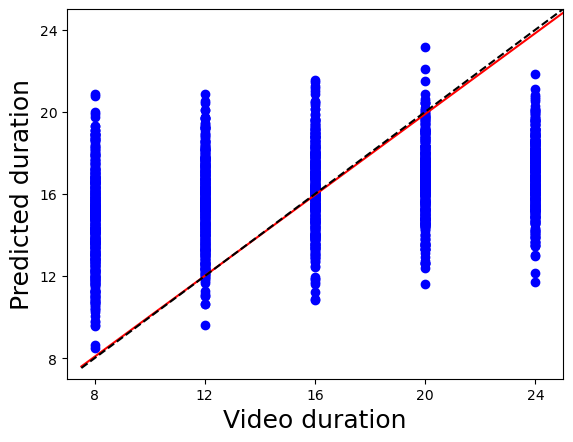

In [15]:
#################################################################################
###################### TREINAMENTO COM LEAVE-ONE-SUBJECT-OUT ############################
#################################################################################

from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#create dataset
class MyDataset(Dataset):
    def __init__(self):
        # Initialize data, download, etc.
        self.n_samples = len(fc_data)

        # here the first column is the class label, the rest are the features
        self.x_data = fc_data
        self.y_data = outcome

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples
        
# create dataset
dataset = MyDataset()
print("=========================")

overwrite = False
load_res = True

counts = samples['subj'].value_counts()
# alpha = 0.5 # Fator de regularização total (combinando L1 e L2)
# l1_list = np.arange(0.1, 1.1, 0.1)  # Proporção de penalização L1 (0 <= l1_ratio <= 1)
l1_list = [1]
n_alphas = 10

region = 'rGlasser'
thr = 'nulo'
task = 'realDur'
data_type = 'smoothed'

for l1_ratio in l1_list:
    
    folder_path = op.join(outdir, 'Elastic-net', region, 'outcome={}_region={}_l1-ratio={}_n-alphas={}_thr={}'.format(
    task, region, l1_ratio, n_alphas, thr))
    if data_type=='smoothed' or data_type=='dubois_pipeline':
        folder_path = op.join(outdir, 'Elastic-net', region, data_type, 'outcome={}_region={}_l1-ratio={}_n-alphas={}_thr={}_RANDOM'.format(
        task, region, l1_ratio, n_alphas, thr))
    print(folder_path)
    outFile = op.join(folder_path, 'results.mat')
    
    if not op.isfile(outFile) or overwrite:
        perf = []
        r2_list = []
        preds = []
        outs = []
        for fold, subj in enumerate(subj_list):
            if str(subj) not in np.ravel(samples['subj']):
                continue
            print(f'Training fold {fold}, includes all subjects but {subj}')
            train_ids = np.ravel(samples.loc[~(samples['subj'] == str(subj)), 'sample'])
            test_ids = np.ravel(samples.loc[(samples['subj'] == str(subj)), 'sample'])
            print(test_ids)
            if len(test_ids)<5:
                print('Test sample is too small, skipping')
                continue
            # Sample elements sequentially from a given list of ids, no replacement.
            train_subsampler = iter(train_ids)
            test_subsampler = iter(test_ids)
            # Define data loaders for training and testing data in this fold
            train_loader = torch.utils.data.DataLoader(
                          dataset, 
                          batch_size=len(train_ids), sampler=train_subsampler)
            test_loader = torch.utils.data.DataLoader(
                          dataset,
                          batch_size=len(test_ids), sampler=test_subsampler)

            # Crie e ajuste o modelo Elastic-Net
            for i, (X_train, y_train) in enumerate(train_loader):
                print(len(X_train))
                elastic_net = ElasticNetCV(l1_ratio=l1_ratio, n_alphas=n_alphas, random_state=42)
                elastic_net.fit(X_train, y_train)

            for i, (X_test, y_test) in enumerate(test_loader):
                # Faça previsões no conjunto de teste
                y_pred = elastic_net.predict(X_test)
                preds.append(list(y_pred))
                outs.append(list(y_test))

                # Avalie o desempenho do modelo
                mse = mean_squared_error(y_test, y_pred)
                rho, p   = stats.pearsonr(np.ravel(y_pred), np.ravel(y_test))
                y_test = y_test.detach().numpy() 
                R2 = 1 - np.sum(np.square(np.log(y_test)-np.log(y_pred))) / np.sum(np.square(np.log(y_test)-np.mean(np.log(y_test))))
                perf.append(rho)
                r2_list.append(R2)
                print(f'Mean Squared Error: {mse}')
                print(f'rho = {rho}, p = {p}, R2 = {R2}')

                # Visualize as previsões e o modelo ajustado
                fig = plt.figure()
                ax = fig.add_axes([0,0,1,1])
                ax.scatter(y_pred, y_test, color='blue', label='Observações reais')
                ax.set_yticks(np.arange(np.min(y_test)-1, np.max(y_test)+1, 5))
                ax.set_xticks(np.arange(np.min(y_pred)-1, np.max(y_pred)+2, 1))
                ax.set_ylabel('Observações')
                ax.set_xlabel('Predições')
                # plt.plot(y_test, y_pred, color='blue', linewidth=3, label='Elastic-Net')
                plt.legend()
                plt.show()

        # saving results
        results = {'rho':np.mean(perf),
                  'fold_perfs':perf,
                  'R2':r2_list,
                  'predicted': preds,
                  'ground_truth':outs
                  }
        if not op.isdir(folder_path):
            os.makedirs(folder_path)
        sio.savemat(outFile, results)

colors = []
if load_res:
    results = sio.loadmat(outFile)
    perf = results['fold_perfs'][0]
    r2_list = results['R2']
    preds = np.squeeze(np.concatenate(results['predicted'][0], axis=1))
    outs = np.squeeze(np.concatenate(results['ground_truth'][0], axis=1))
for R2 in r2_list[0]:
    if R2<0:
        colors.append('r')
    else:
        colors.append('b')
        
print(f'Mean rho is: {np.mean(perf)} +/- {np.std(perf)}')
print(f'Mean R2 is: {np.mean(r2_list)} +/- {np.std(r2_list)}')

# global results
rho,p = stats.pearsonr(np.ravel(preds), np.ravel(outs))
R2 = r2_score(np.ravel(outs), np.ravel(preds))
modelo = sm.OLS(outs, sm.add_constant(preds)).fit()
print(f'Global corr = {rho:.3f}, p = {p:.3f} and global R2 is {R2:.3f}')
print('------> Linear Regression between observed and model {}: beta = {:.2f} ± {:.2f}, p = {:.3f}'
                                  .format(task, modelo.params[1], modelo.bse[1], modelo.f_pvalue))

samples['predicted'] = preds
samples = samples.rename(columns={'dur':'duration'})

# PLOTAR PRED X OUTCOME
b, a = modelo.params
ident = np.arange(min(preds)-1, max(preds)+1)
linReg = b + a * ident

fig = plt.figure()
# ax = fig.add_axes([0,0,1.4,1])
plt.scatter(outs, preds, color='blue')
plt.plot(ident, linReg, color='red')
plt.plot(ident, ident, color='black', linestyle='--')
# ax.set_xticks(X)
# ax.set_xticklabels(np.arange(0, len(labels), 1), rotation = (45), fontsize = 8)
#         ax.set_yticks(np.arange(0, 1.1, 0.1))
# ax.set_yticks(np.arange(0, 0.8, 0.1))
# plt.yticks(fontsize=12)
plt.ylabel('Predicted duration', fontsize=18)
plt.xlabel('Video duration', fontsize=18)
plt.ylim([7, 25])
plt.xlim([7, 25])
plt.xticks(np.arange(8, 25, 4))
plt.yticks(np.arange(8, 25, 4))
# ax.legend(labels=['Inter-network', 'Intra-network'])
plt.show()

In [56]:
# organising data
resdir = 'D:\\ERICK\\MD\\Results\\'
# origdir = 'D:\\ERICK\\MD\\predictions (ORIGINAL)\\'
regions = ['rGlasser']
excluded = [41, 45]
layers = [1, 2, 3]
df_glasser = []

load_file = op.join(datadir, 'master_dataset.csv')
df = pd.read_csv(load_file)

for subject in range(4, 46):
    if subject in excluded:
        df = df[df['rawSubjID'] != subject]
        continue
for region in regions:
    data = {'subj': [], 'duration': [], 'isCity': [], 'report': [], 'humanBias': []}
    data['subj'] = df['subj']
    data['duration'] = df['veridicalDuration']
    data['isCity'] = df['isCity']
    data['report'] = df['humanReport']
    data['humanBias'] = df['humanBias']
    data['FC'] = fc_data

#     df_glasser = pd.DataFrame(data)

# df_glasser = pd.concat(df_glasser, ignore_index=True)

In [4]:
#calculate model bias for each subject
files = ['rGlasser']
durations = [8, 12, 16, 20, 24]
dur_dic = {8:0, 12:1, 16:2, 20:3, 24:4}
modelBias_off = {'rGlasser':[]}
modelBias_city = {'rGlasser':[]}
avgmb_diff = {'rGlasser':[]}
modelBias_all = {'rGlasser':[]}
avgmb_all = {'rGlasser':[]}
avgmb_c = {'rGlasser':[]}
avgmb_o = {'rGlasser':[]}
# outdir = 'D:\\ERICK\\MD\\predictions (ORIGINAL)\\'

for region in files:
    print(region)
    save_file = op.join(outdir, 'predicted_FC_{}.csv'.format(region))
    data = samples
    for subj in range(4, 45): # mudar caso mude o tamanho da amostra
        subset_c = data.loc[(data['subj'] == str(subj)) & (data['isCity'] == 1)]
        subset_o = data.loc[(data['subj'] == str(subj)) & (data['isCity'] == 0)]
        subset = data.loc[(data['subj'] == str(subj))]
        mb_subcity = []
        mb_suboff = []
        mb_suball = []
    
        if len(subset_c) != 0:
            print(f'Sujeito {subj} existe')
    
            for dur in durations:
                mean_dur = subset.groupby('duration')['predicted'].mean().tolist() 
            for ind, row in subset.iterrows():
                modelrep = row['predicted']
                md_idx = dur_dic[row['duration']]
                model_bias = 100*(modelrep-mean_dur[md_idx])/mean_dur[md_idx]
                mb_suball.append(model_bias)
                modelBias_all[region].append(model_bias)
            for ind, row in subset_c.iterrows():
                modelrep = row['predicted']
    #             print('predicted is', modelrep)
                md_idx = dur_dic[row['duration']]
    #             print('mean dur is', mean_dur_c[md_idx])
                model_bias = 100*(modelrep-mean_dur[md_idx])/mean_dur[md_idx]
    #             print('model bias is', model_bias)
                mb_subcity.append(model_bias)
                modelBias_city[region].append(model_bias)
            for ind, row in subset_o.iterrows():
                modelrep = row['predicted']
                md_idx = dur_dic[row['duration']]
                model_bias = 100*(modelrep-mean_dur[md_idx])/mean_dur[md_idx]
                mb_suboff.append(model_bias)
                modelBias_off[region].append(model_bias)
            #calculate diff
            diff = np.mean(mb_subcity)-np.mean(mb_suboff)
    #         print(diff)
            avgmb_diff[region].append(diff)
            #average within subject
            avgmb_c[region].append(np.mean(mb_subcity))
            avgmb_o[region].append(np.mean(mb_suboff))
            avgmb_all[region].append(np.mean(mb_suball))
        
    #overwrite file
    data['modelBias'] = modelBias_all[region]
    data.to_csv(save_file, sep=',', encoding='utf-8')

In [12]:
# statistical analyses
# outdir = 'D:\\ERICK\\MD\\predictions (ORIGINAL)\\'
files = ['rGlasser']
columns = ['Região', 'Viés de duração', '95% IC', 'chi-quadrado', 'valor-p']
df = pd.DataFrame(columns=columns)
n=38

for region in files: 
    print('--------------------------------')
    print(region)
    model_file = op.join(outdir, 'predicted_FC_{}.csv'.format(region))
    model_data = pd.read_csv(model_file)
    
#     #plot model bias hist
#     plt.hist(model_data['modelBias'])
#     plt.show()
    
    #Regressão => bias (human) = B0 + B1 * bias (model)
    x = model_data['modelBias']
    y = model_data['humanBias']
    #corr
    rho,p = stats.pearsonr(x, y)
    R2 = 1 - np.sum(np.square(y-x)) / np.sum(np.square(y-np.mean(y)))
    print('Correlation between human and model bias: r = {:.2f}, p = {:.3f}'
          .format(rho, p))
    print('R2 = {:.2f}'.format(R2))
    modelo = sm.OLS(y, sm.add_constant(x)).fit()
    print('Linear Regression between human and model bias: beta = {:.2f} ± {:.2f}, p = {:.3f}'
          .format(modelo.params[1], modelo.bse[1], modelo.f_pvalue))
    
    #EFEITO FIXO = MODEL BIAS
    vc = {'subj': '1 + C(subj)'}
    # Ajustar o modelo reduzido sem o efeito fixo
    model_reduced = sm.MixedLM.from_formula("humanBias ~ 1", vc_formula=vc, data=model_data, groups=model_data['subj'])
    result_reduced = model_reduced.fit()
    # Ajustar o modelo completo com o efeito fixo
    model_full = sm.MixedLM.from_formula("humanBias ~ 1 + modelBias", vc_formula=vc, data=model_data, groups=model_data['subj'])
    result_full = model_full.fit()
    # Calcular a diferença nas log-verossimilhanças
    llf_full = result_full.llf
    llf_reduced = result_reduced.llf
    lrt = -2 * (llf_reduced - llf_full)
    # Calcular o valor p do teste
    p_value = chi2.sf(lrt, 1)
    print('Using model bias as fixed effect: chi-sqr = {:.2f}, p = {:.3f}'
          .format(lrt, p_value))
    
    #EFEITO FIXO = CENA
    vc = {'subj': '1 + C(subj)'}
    # Ajustar o modelo reduzido sem o efeito fixo
    model_reduced = sm.MixedLM.from_formula("modelBias ~ 1", vc_formula=vc, data=model_data, groups=model_data['subj'])
    result_reduced = model_reduced.fit()
    # Ajustar o modelo completo com o efeito fixo
    model_full = sm.MixedLM.from_formula("modelBias ~ 1 + isCity", vc_formula=vc, data=model_data, groups=model_data['subj'])
    result_full = model_full.fit()
    # Calcular a diferença nas log-verossimilhanças
    llf_full = result_full.llf
    llf_reduced = result_reduced.llf
    lrt = np.round(-2 * (llf_reduced - llf_full), 2)
    # Calcular o valor p do teste
    p_value = np.round(chi2.sf(lrt, 1), 3)
    #calculate and print statistics
    mean = np.round(np.mean(avgmb_diff[region]), 2)
    SE = np.round(np.std(avgmb_diff[region], ddof=1)/np.sqrt(n), 2)
    z = 1.96  # Valor crítico para um intervalo de confiança de 95%
    lower_bound = np.round(mean - (z * SE), 2)
    upper_bound = np.round(mean + (z * SE), 2)
    print('Using scene as fixed effect: M±SEdiff = {:.2f} ± {:.2f} (normalized bias, %), 95% CI [{:.2f}, {:.2f}], chi-sqr = {:.2f}, p = {:.3f}'
          .format(mean, SE, lower_bound, upper_bound, lrt, p_value))
    
    linha = [region, '{} ± {}'.format(mean, SE), [lower_bound, upper_bound], lrt, p_value]
    df.loc[len(df)] = linha
    
# outFile = op.join(outdir, 'lmm_table_rep.csv')
# df.to_csv(outFile, sep=',', encoding='utf-8')

--------------------------------
rGlasser
Correlation between human and model bias: r = -0.01, p = 0.556
R2 = -0.11
Linear Regression between human and model bias: beta = -0.04 ± 0.07, p = 0.556
Using model bias as fixed effect: chi-sqr = -3.20, p = 1.000
Using scene as fixed effect: M±SEdiff = 0.44 ± 0.54 (normalized bias, %), 95% CI [-0.62, 1.50], chi-sqr = 0.98, p = 0.322


In [5]:
#################################################################################
###################### CLASSIFICAÇÃO TIPO DE VÍDEO ############################
#################################################################################

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay

#create dataset
class MyDataset(Dataset):
    def __init__(self):
        # Initialize data, download, etc.
        self.n_samples = len(fc_data)

        # here the first column is the class label, the rest are the features
        self.x_data = fc_data
        self.y_data = outcome

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples
        
# create dataset
dataset = MyDataset()
print("=========================")
# task = 'videoType'
# region = 'visualNet'

overwrite = True
load_res = True

counts = samples['subj'].value_counts()
l1_ratio=0.5

folder_path = op.join(outdir, 'Logistic Regression', region, 'outcome={}_region={}_l1-ratio={}_TESTE'.format(
    task, region, l1_ratio))
print(folder_path)
if not op.isdir(folder_path):
    os.makedirs(folder_path)
outFile = op.join(folder_path, 'results.mat')

if not op.isfile(outFile) or overwrite:
    perf = []
    auc_list = []
    preds = []
    outs = []
    for fold, subj in enumerate(subj_list):
        if str(subj) not in np.ravel(samples['subj']):
            continue
        print(f'Training fold {fold}, includes all subjects but {subj}')
        train_ids = np.ravel(samples.loc[~(samples['subj'] == str(subj)), 'sample'])
        test_ids = np.ravel(samples.loc[(samples['subj'] == str(subj)), 'sample'])
        print(test_ids)
        # Sample elements sequentially from a given list of ids, no replacement.
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
        # Define data loaders for training and testing data in this fold
        train_loader = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=len(train_ids), sampler=train_subsampler)
        test_loader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=len(test_ids), sampler=test_subsampler)

        # Crie e ajuste o modelo
        for i, (X_train, y_train) in enumerate(train_loader):
            print(len(X_train))
            model = LogisticRegression(solver='saga', penalty="elasticnet", l1_ratio=l1_ratio, max_iter=50)
            model.fit(X_train, y_train)

        for i, (X_test, y_test) in enumerate(test_loader):
            # Faça previsões no conjunto de teste
            y_pred = model.predict_proba(X_test)[:, 1]
            preds.append(y_pred)
            outs.append(y_test)

            # Avalie o desempenho do modelo
            y_test = y_test.detach().numpy() 
            acc = accuracy_score(y_test, y_pred > 0.5)
            perf.append(acc)
            auc = roc_auc_score(y_test, y_pred)
            auc_list.append(auc)
            print(f'acc = {acc} and auc = {auc}')

#             # Visualize as previsões e o modelo ajustado
#             fig = plt.figure()
#             ax = fig.add_axes([0,0,1,1])
#             ax.scatter(y_pred, y_test, color='blue', label='Observações reais')
#             ax.set_yticks(np.arange(-3, 4, 1))
#             ax.set_xticks(np.arange(-3, 4, 1))
#             ax.set_ylabel('Observações')
#             ax.set_xlabel('Predições')
#             # plt.plot(y_test, y_pred, color='blue', linewidth=3, label='Elastic-Net')
#             plt.legend()
#             plt.show()
            
    # saving results
    results = {'acc':perf,
               'auc':auc_list,
              'fold_perfs':perf,
              'predicted': preds,
              'ground_truth':outs}
    sio.savemat(outFile, results)

if load_res:
    results = sio.loadmat(outFile)
    perf = results['fold_perfs'][0]
    preds = np.squeeze(np.concatenate(results['predicted'][0], axis=1))
    outs = np.squeeze(results['ground_truth'])
    auc_list = results['auc']
        
print(f'Mean acc is: {np.mean(perf)} +/- {np.std(perf)} and mean auc is: {np.mean(auc_list)} +/- {np.std(auc_list)}')

#ROC curve
plt.figure()
outcome = np.squeeze(np.concatenate(outs, axis=1))
auc = roc_auc_score(outcome, preds)
print(f'Final AUC score: {auc}')

RocCurveDisplay.from_predictions(outcome, preds)

plt.title(f'ROC Curve')
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
# plt.savefig(op.join(thisOutDir, 'Figures', "ROC_{}.jpeg".format(session)), format='jpeg')

# plotar resumo dos resultados
X = np.arange(len(perf))
#         colors = ['r']*(len(perf))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
bar = ax.bar(X, perf, width = 0.9, capsize=5)
# ax.errorbar(X, perf, error, fmt='o', ecolor = 'black', color='green')
#         ax.bar_label(bar, fmt='%.3f', fontsize = 10)
ax.set_xticks(X)
# ax.set_xticklabels(np.arange(0, len(labels), 1), rotation = (45), fontsize = 8)
#         ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_yticks(np.arange(0, 1.1, 0.1))
plt.yticks(fontsize=12) 
# ax.set_ylabel(ylabel, fontsize=18)
# ax.legend(labels=['Inter-network', 'Intra-network'])
plt.title('Tipo de Vídeo', fontsize=25)
plt.show()

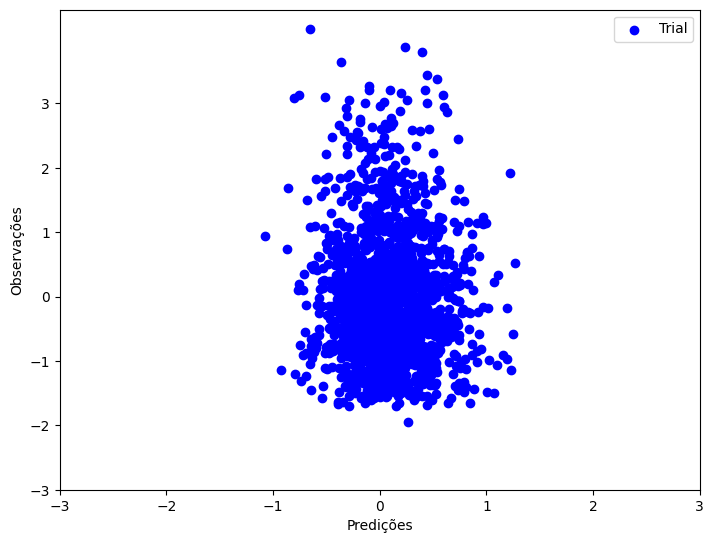

In [40]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(preds, outcome, color='blue', label='Trial')
ax.set_yticks(np.arange(-3, 4, 1))
ax.set_xticks(np.arange(-3, 4, 1))
ax.set_ylabel('Observações')
ax.set_xlabel('Predições')
# plt.plot(y_test, y_pred, color='blue', linewidth=3, label='Elastic-Net')
plt.legend()
plt.show()